In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers
from PIL import Image

In [3]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
def load_images(folders, label_map):
    # creating two lists to store the images and labels
    images = []
    labels = []

    # loading the images from each folder in the dataset
    for folder in folders:
        for category in os.listdir(folder):
            category_path = os.path.join(folder, category)
            if os.path.isdir(category_path):
                if category in label_map:  # Check if the category is present in the label_map
                    label = label_map[category]
                    file_list = os.listdir(category_path)
                    for filename in file_list:
                        img_path = os.path.join(category_path, filename)
                        image = cv2.imread(img_path)
                        # resizing the images to create a standard and so that it can be suitable for the model input
                        image = cv2.resize(image, (224, 224))
                        # cv2 reads the image as BGR so we need to convert it back to RGB
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        images.append(image)
                        labels.append(label)

    return np.array(images), np.array(labels)

In [5]:
#Zugriff für Google Drive erlauben
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_folders = [
    '/content/drive/My Drive/brain_tumor_dataset_3/',
]

# encoding the labels
label_map = {'no': 0, 'yes': 1}  # Map negative to 0 (no) and positive to 1 (yes)

images, labels = load_images(data_folders, label_map)

print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

Shape of images: (1000, 224, 224, 3)
Shape of labels: (1000,)


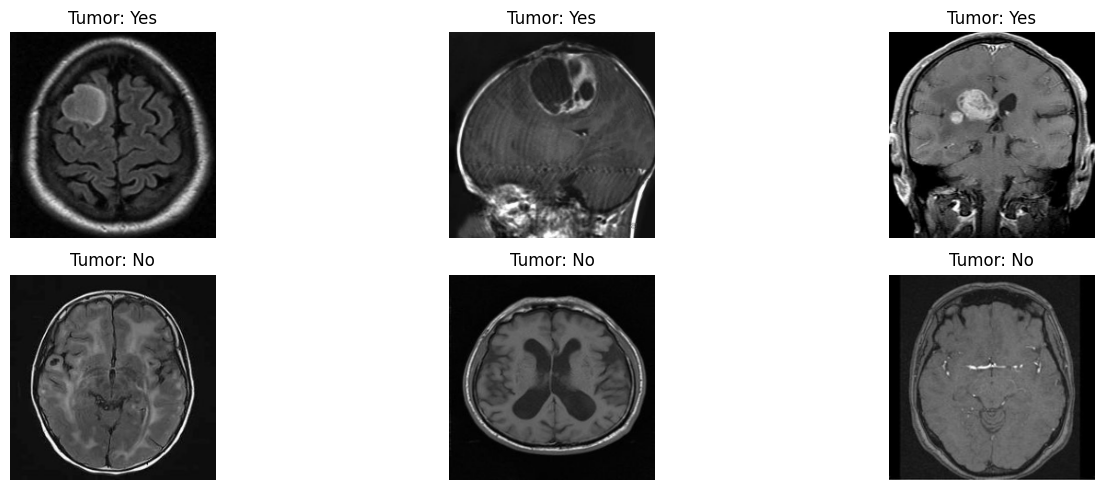

In [7]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[labels == 1][i])  # Filter images with label 'yes'
    plt.title("Tumor: Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(images[labels == 0][i])  # Filter images with label 'no'
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()

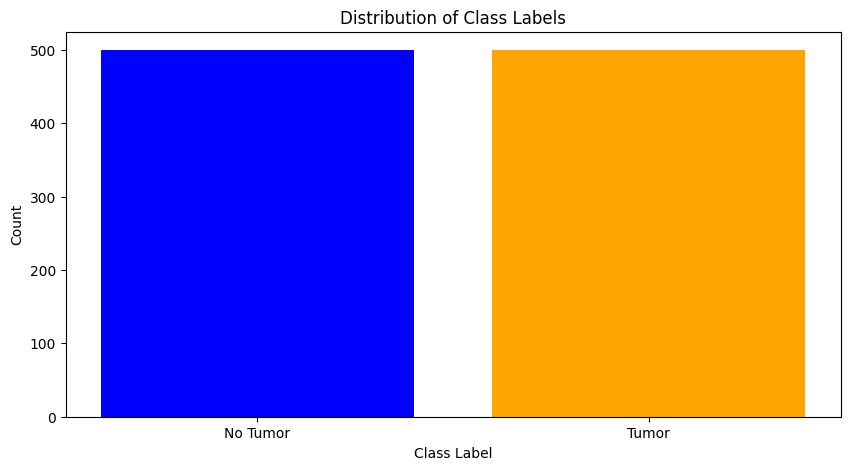

In [8]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [9]:
def crop_brain_region(image, size):

    # Converting the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Applying Gaussian blur to smooth the image and reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding the image to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    # Performing morphological operations to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Finding contours in the binary mask
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the brain part of the image has the largest contour
    c = max(contours, key=cv2.contourArea)

    # Getting the bounding rectangle of the brain part
    x, y, w, h = cv2.boundingRect(c)

    # Drawing contours on the original image
    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)

    # Drawing bounding box on the original image
    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Cropping the image around the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]

    # Resizing cropped image to the needed size
    resized_image = cv2.resize(cropped_image, size)

    return contour_image, bounding_box_image, cropped_image, resized_image

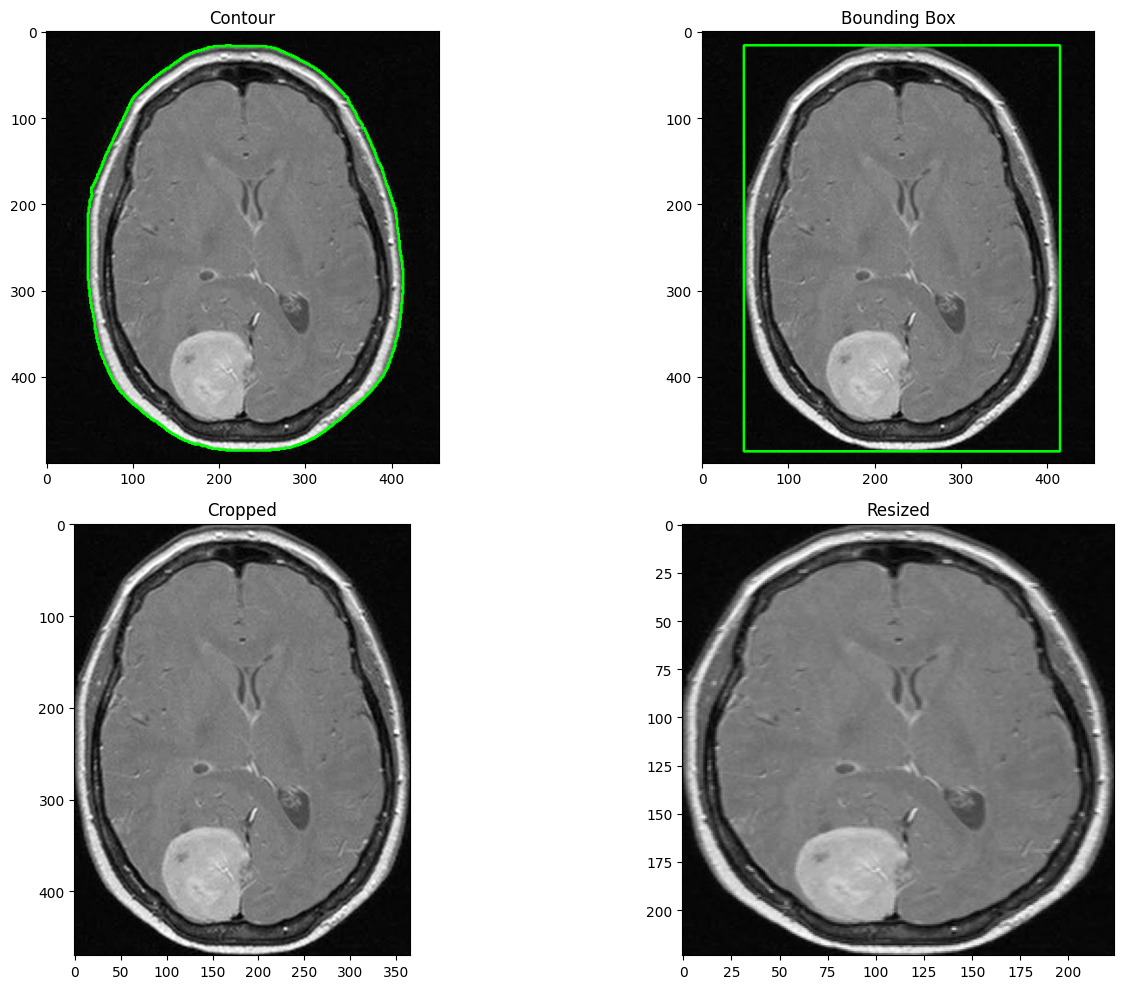

In [10]:
output_size = (224, 224)

example_image = cv2.imread('//content/drive/My Drive/brain_tumor_dataset_3/yes/m1(98).jpg')
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

contour_image, bounding_box_image, cropped_image, resized_image = crop_brain_region(example_image, output_size)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(contour_image)
plt.title("Contour")

plt.subplot(2, 2, 2)
plt.imshow(bounding_box_image)
plt.title("Bounding Box")

plt.subplot(2, 2, 3)
plt.imshow(cropped_image)
plt.title("Cropped")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Resized")

plt.tight_layout()
plt.show()

all_cropped = []

# Applying the crop function to each one of our images
for image in images:
    _, _, _, resized_image = crop_brain_region(image, output_size)
    all_cropped.append(resized_image)

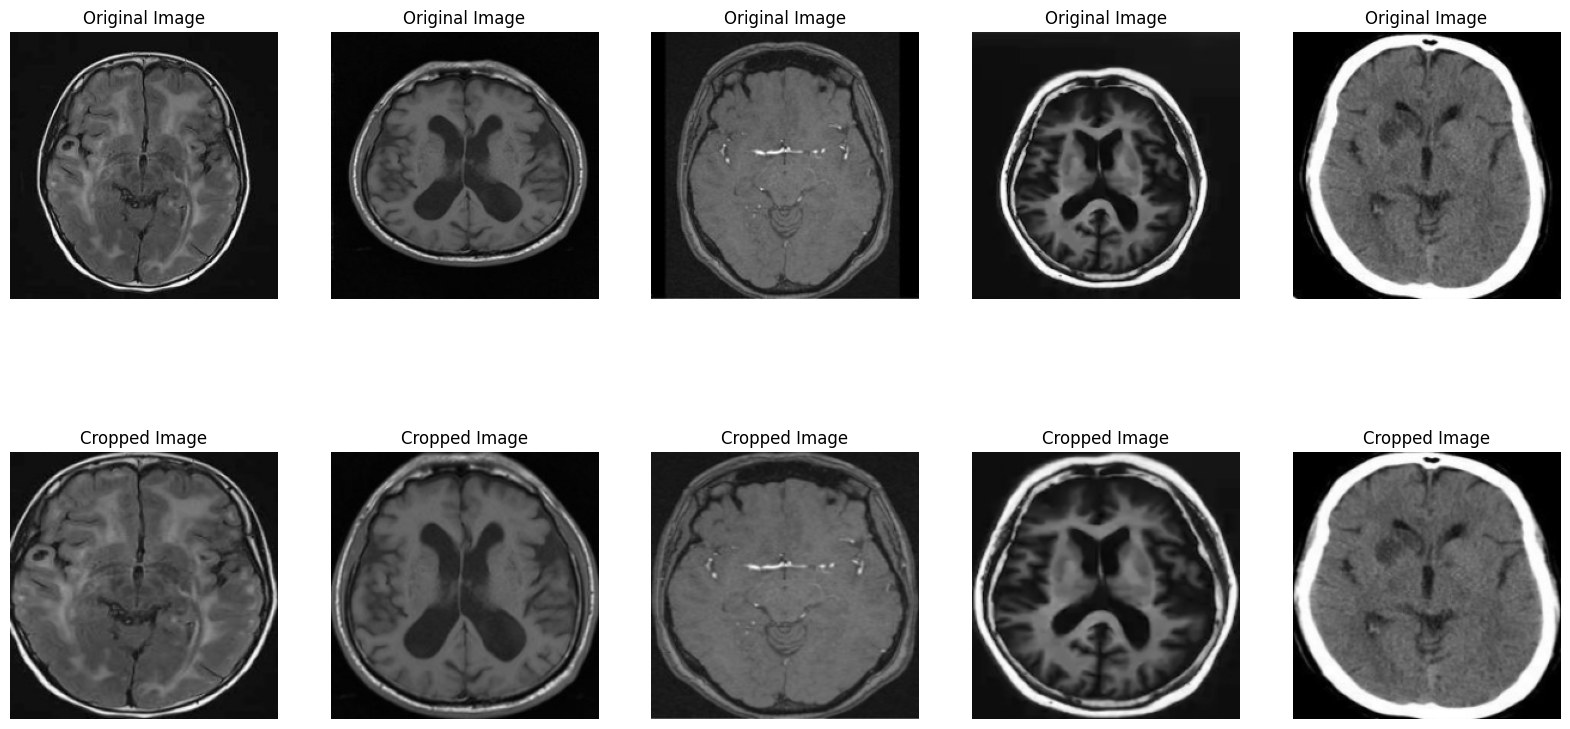

In [11]:

num_images_per_class = 5

class_0_counter = 0
class_1_counter = 0

plt.figure(figsize=(20, 10))

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, i + 1)
    plt.imshow(images[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(all_cropped[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.show()

In [13]:
all_cropped=np.array(all_cropped)

X_train, X_test, y_train, y_test = train_test_split(all_cropped, labels, test_size=0.2,shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (800, 224, 224, 3)
X_val shape: (100, 224, 224, 3)
X_test shape: (100, 224, 224, 3)
y_train shape: (800,)
y_val shape: (100,)
y_test shape: (100,)


In [14]:
train_folder = 'Train'
val_folder = 'Validation'
test_folder = 'Test'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

label_map_decoded = {1: 'yes', 0: 'no'}

def copy_images_to_folder(images, labels, folder):
    for i, (image, label) in enumerate(zip(images, labels)):
        class_name = label_map_decoded[label]
        class_folder = os.path.join(folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        img_filename = f'{class_name}_{i}.jpg'  # Assuming images are in JPG format
        img_path = os.path.join(class_folder, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Save image directly without converting to PIL format

In [15]:
copy_images_to_folder(X_train, y_train, train_folder)
copy_images_to_folder(X_val, y_val, val_folder)
copy_images_to_folder(X_test, y_test, test_folder)

In [18]:
print("Größe vorher:")
print(np.max(X_train))
print(np.min(X_train))

X_train_scaled=X_train/255
X_test_scaled=X_test/255
X_val_scaled=X_val/255

print("Größe nachher:")
print(np.max(X_train_scaled))
print(np.min(X_train_scaled))

Größe vorher:
255
0
Größe nachher:
1.0
0.0


Standard CNN Modell

In [19]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [20]:
epochs = 50
batch_size = 32

early_stopping = EarlyStopping(patience=5, monitor='val_loss')  # Defining early stopping to stop the model from overfitting


history = model.fit(X_train_scaled,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val_scaled,y_val),
                   callbacks=[early_stopping])

Epoch 1/50
25/25 [==============================] - 97s 4s/step - loss: 0.6808 - accuracy: 0.5475 - val_loss: 0.6898 - val_accuracy: 0.4200
Epoch 2/50
25/25 [==============================] - 122s 5s/step - loss: 0.6356 - accuracy: 0.6612 - val_loss: 0.5739 - val_accuracy: 0.6900
Epoch 3/50
25/25 [==============================] - 123s 5s/step - loss: 0.5717 - accuracy: 0.7275 - val_loss: 0.5197 - val_accuracy: 0.7300
Epoch 4/50
25/25 [==============================] - 110s 4s/step - loss: 0.5055 - accuracy: 0.7688 - val_loss: 0.4791 - val_accuracy: 0.7300
Epoch 5/50
25/25 [==============================] - 102s 4s/step - loss: 0.5136 - accuracy: 0.7713 - val_loss: 0.5415 - val_accuracy: 0.7300
Epoch 6/50
25/25 [==============================] - 96s 4s/step - loss: 0.4706 - accuracy: 0.7975 - val_loss: 0.4523 - val_accuracy: 0.7200
Epoch 7/50
25/25 [==============================] - 95s 4s/step - loss: 0.3971 - accuracy: 0.8375 - val_loss: 0.4291 - val_accuracy: 0.7900
Epoch 8/50
25/25

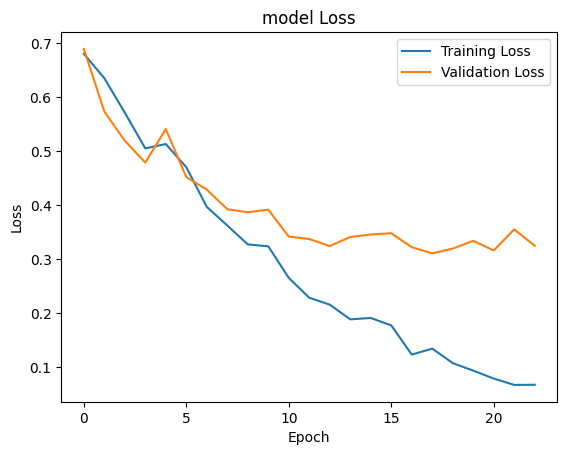

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

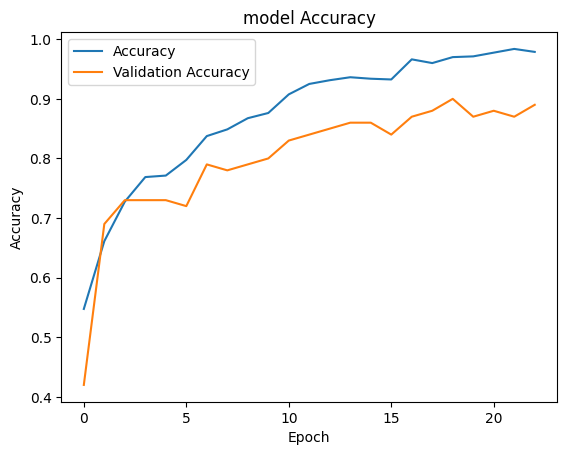

In [22]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4/4 [==============================] - 4s 686ms/step
Accuracy on Validation Set: 0.890 %


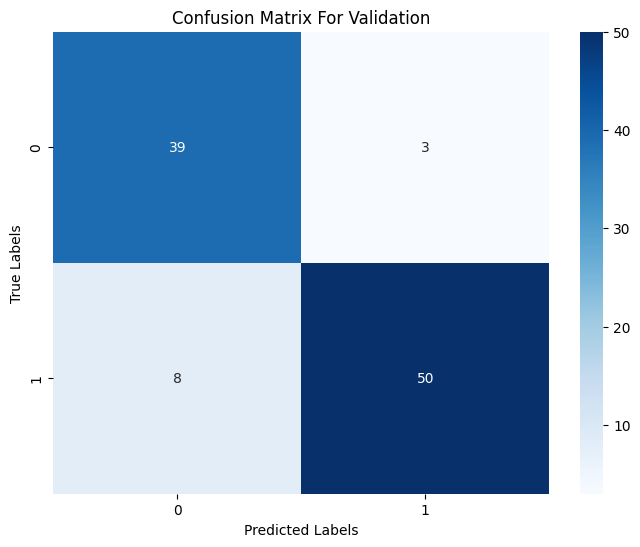

In [23]:
predictions = model.predict(X_val_scaled)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

4/4 [==============================] - 3s 713ms/step
Accuracy on Test Set: 0.890 %


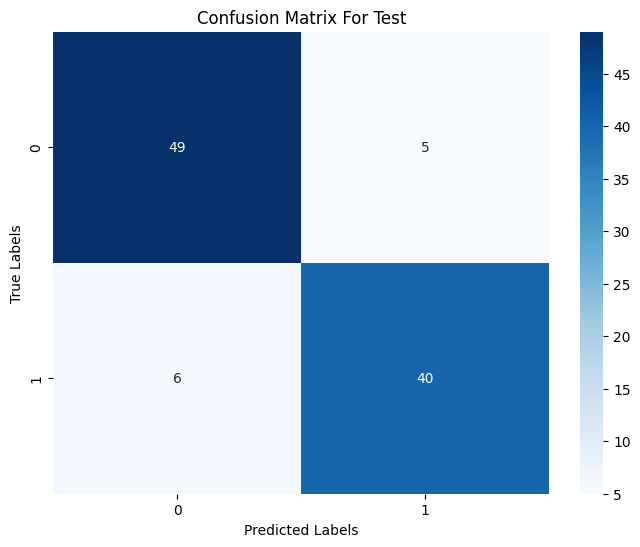

In [24]:
predictions = model.predict(X_test_scaled)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Datenerweiterung und VGG16

In [25]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)

image_size=(224,224)

train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_folder,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

Found 800 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


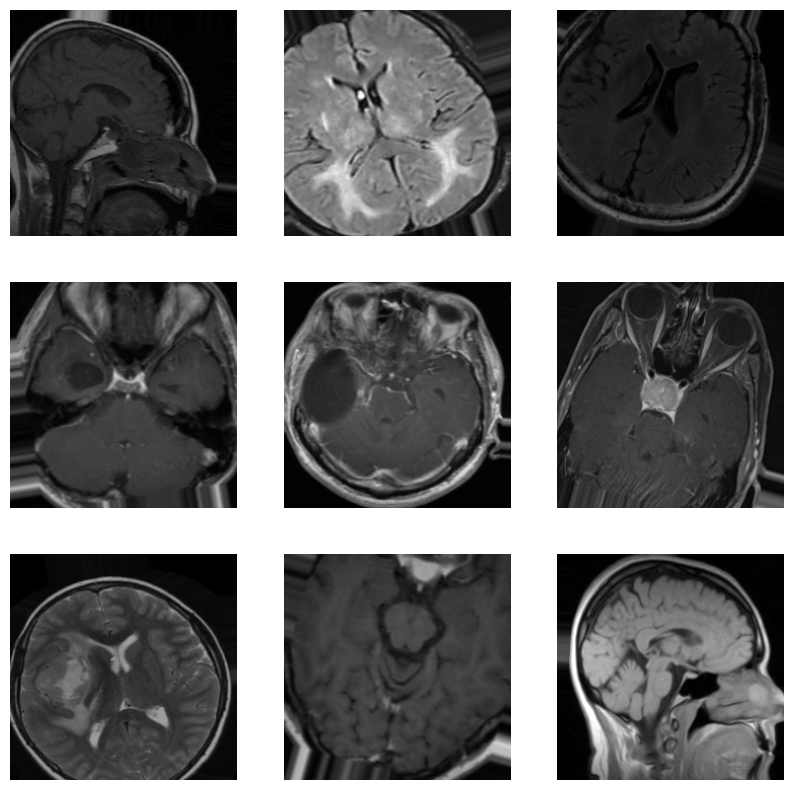

In [26]:
augmented_images, _ = datagen.flow(X_train, y_train, batch_size=32).next()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [27]:
base_model = VGG16(weights='/content/drive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-5]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4), metrics=['accuracy'])

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
25/25 [==============================] - 677s 27s/step - loss: 0.7049 - accuracy: 0.5750 - val_loss: 0.5627 - val_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 2/200
25/25 [==============================] - 664s 27s/step - loss: 0.5746 - accuracy: 0.7212 - val_loss: 0.4599 - val_accuracy: 0.8200 - lr: 1.0000e-04
Epoch 3/200
25/25 [==============================] - 661s 27s/step - loss: 0.4764 - accuracy: 0.7775 - val_loss: 0.4107 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 4/200
25/25 [==============================] - 683s 27s/step - loss: 0.4261 - accuracy: 0.7937 - val_loss: 0.4494 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 5/200
25/25 [==============================] - 685s 27s/step - loss: 0.4010 - accuracy: 0.8275 - val_loss: 0.2872 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 6/200
25/25 [==============================] - 683s 27s/step - loss: 0.3516 - accuracy: 0.8413 - val_loss: 0.2846 - val_accuracy: 0.9100 - lr: 1.0000e-04
Epoch 7/200
25/25 [=====================

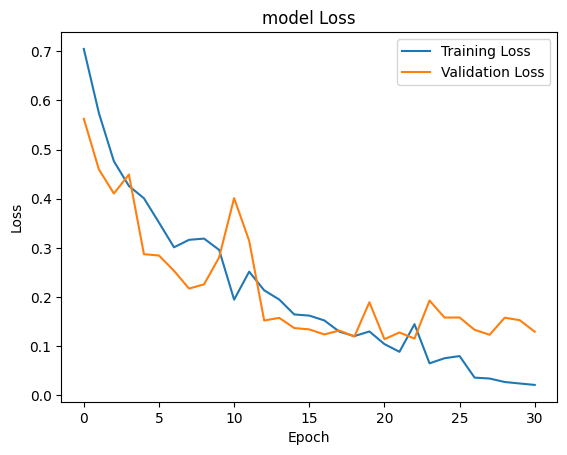

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

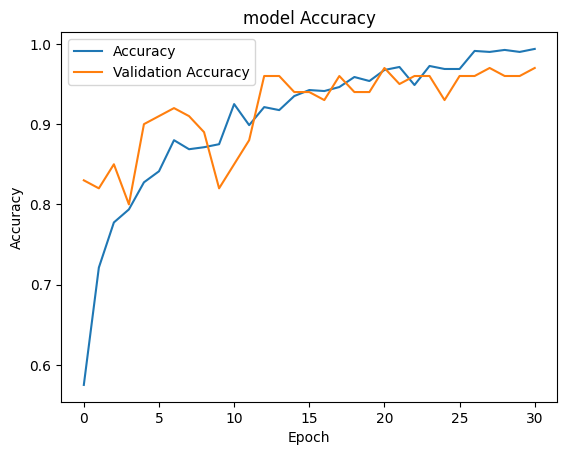

In [30]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4/4 [==============================] - 61s 14s/step
Accuracy on Validation Set: 0.970000


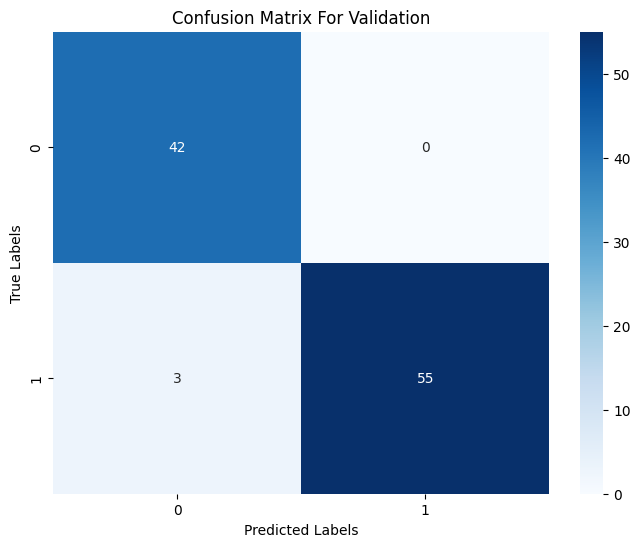

In [31]:
predictions = model.predict(X_val_scaled)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

4/4 [==============================] - 64s 15s/step
Accuracy on Test Set: 0.960000


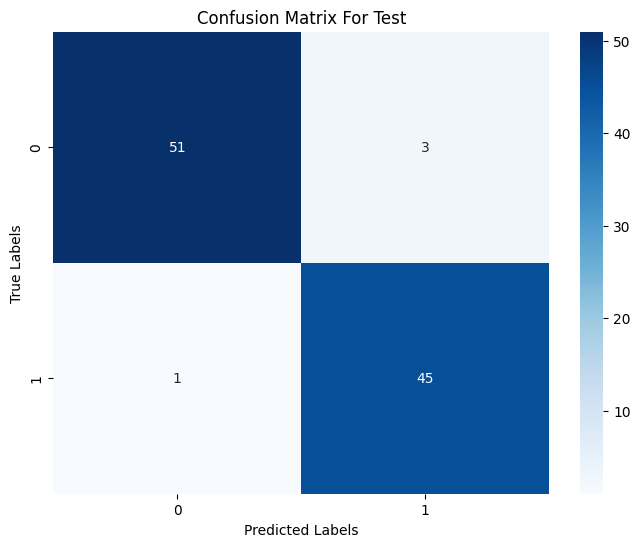

In [32]:
predictions = model.predict(X_test_scaled)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()